# Exercise Sheet 5 - Variational Autoencoders

- Deep Learning for Computer Vision - Winter Term 2023/24
- Organizers: Anwai Archit, Sushmita Nair, Constantin Pape
- Tutors: Ahsan Ali, Anwai Archit, Lukas Friedrich, Piklu Mallick, Sushmita Nair, Ayush Paliwal
- Due date: **Tuesday**, Jan 16, before 10:00

In this exercise a variational autoencoder (VAE) shall be implemented and trained on the fashion MNIST dataset. VAEs are an example of generative deep learning and can be used to synthesize data - images in this case - which shall also be demonstrated in this exercise!

### IMPORTANT SUBMISSION INSTRUCTIONS

- **You need to answer all the questions in written form**
- When you're done, download the notebook and **rename** it to ```<surname1>_<surname2>_<surname3>.ipynb```
- Only submit the Jupyter Notebook (ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 5`
- Make only one submission of the exercise per group.
- The deadline is strict
- You have to present the exercise in the tutorials. We have a high ratio of students to tutors, so please decide which team member presents which part beforehand.

### TASKS
* TASK 1: Implement a VAE
* TASK 2: Train the model and plot train and test set loss over training in the same plot
* TASK 3: Determine optimal dimensionality of latent space
* TASK 4: Plot some latent traversals
* TASK 5: Visualize class labels in latent space

## Setup and Requirements

### Imports

In [2]:
from __future__ import print_function
import pathlib

import matplotlib.pyplot as plt

import os
import numpy as np
from barbar import Bar
import pandas as pd
from tqdm import tqdm
from glob import glob
import imageio.v3 as imageio

import seaborn as sns

import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import torchvision.utils

import numpy as np

!nvcc --version
!python --version
print(torch.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
Python 3.10.12
2.0.0


In [3]:
#
# FOR TRAINING
#


def run_training(
        train_loader, val_loader, net, num_epochs, criterion, optimizer, scheduler=None, early_stopping=None, device="cpu"
):
    """This function runs the training scheme for the training dataset, and validates on the validation dataset as well

    Arguments:
        train_loader: The training dataloader
        val_loader: The validation dataloader
        net: The model architecture to perform the training on
        num_epochs: The total number of epochs to train the models for
        criterion: The loss function
        optimizer: The optimizer object
        scheduler: The learning rate scheduler (the workflow is suited right now for `ReduceLROnPlateau`)
        early_stopping: The early stopping functionality
        device: The torch device

    Returns:
        accuracy: The accuracy on training set
        val_accuracy: The accuracy on validation set
        losses: The losses on training set (per epoch)
        val_losses: The losses on validation set (per epoch)
    """
    accuracy, val_accuracy = [], []
    losses, val_losses = [], []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_total = 0.0
        num_samples_total = 0.0
        for i, data in enumerate(Bar(train_loader)):
            # getting the training inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # setting the parameter gradients to zero
            optimizer.zero_grad()

            # forward pass, backward pass, optimize
            outputs, mu, logvar = net(inputs)
            loss = criterion(outputs, inputs, mu, logvar)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        running_loss /= len(train_loader)
        val_loss = evaluate(net, criterion, val_loader, device)

        if scheduler is not None:
            # decay the learning rate
            if type(scheduler) == torch.optim.lr_scheduler.ReduceLROnPlateau:
                # here, you can potentially track on either of the two metrics: val loss or val accuracy
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        print('Epoch: %d' % (epoch + 1))
        print('Training Loss: %.3f  => Validation Loss: %.3f' % (running_loss, val_loss))

        losses.append(running_loss)  # list containing the training losses
        val_losses.append(val_loss)  # list containing the validation losses

        if early_stopping is not None:
            # early stopping needs to check the validation loss if it decreases, and saves checkpoint of current best model
            early_stopping(val_loss, net)

            if early_stopping.early_stop:
                print("Early Stopping...")
                break

    print('Finished Training')
    return losses, val_losses


#
# FOR METRICS AND VALIDATION EVALUATION
#


def get_accuracy(predicted, labels):
    "Function to obtain the accuracy between the predicted labels and true labels"
    batch_len, correct = 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    return batch_len, correct


def evaluate(model, criterion, val_loader, device):
    "Function to perform evaluation for the respective models"
    losses = 0
    num_samples_total = 0
    #correct_total = 0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        out, mu, logvar = model(inputs)
        loss = criterion(out, inputs, mu, logvar)
        losses += loss.item()
        #b_len, corr = get_accuracy(predicted, labels)
        num_samples_total += loss
        #correct_total += corr
    #accuracy = correct_total / num_samples_total
    losses = losses / len(val_loader)
    return losses#, accuracy


class EarlyStopping:
    "Function to stop the training early, if the validation loss doesn't improve after a predefined patience."
    def __init__(self, checkpoint_path, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.model_checkpoint_path = checkpoint_path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping Counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation Loss Decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.model_checkpoint_path)
        self.val_loss_min = val_loss


def get_metric_plots(train_metric, val_metric, metric_name: str = None):
    "Function to plot the respective metric (accuracy or loss) for training and validation"
    plt.figure()
    plt.plot(train_metric)
    plt.plot(val_metric)
    if metric_name is not None:
        plt.title(metric_name.upper())
        plt.ylabel(metric_name)
    else:
        print("It's expected to pass the name of metrics in the `metric_name` argument. (e.g. if you are visualizing train and val accuracies, please provide `metric_name=\"accuracy\"`, etc.)")
    plt.xlabel('epochs')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()


#
# FOR TEST EVALUATION
#


def test_evaluation(net, test_loader, device):
    "Function to get the test evaluation on the respective model"
    correct = 0
    total = 0
    net.eval()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct, total


def get_confusion_matrix(classes, test_loader, net, device, view_cm=False):
    confusion_matrix = torch.zeros(len(classes), len(classes))
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    if view_cm:
        print(confusion_matrix, "\n")
    cm = confusion_matrix.numpy()
    return cm


def get_metrics_from_confusion_matrix(cm, chosen_index):
    total = np.sum(cm)
    idx = chosen_index
    recall = cm[idx][idx] / np.sum(cm[:, idx])
    precision = cm[idx][idx] / np.sum(cm[idx])
    accuracy = cm[idx][idx] + (total - np.sum(cm[idx]) - np.sum(cm[:, idx]) + cm[idx][idx])
    return recall, precision, accuracy / total


def check_precision_recall_accuracy(cm, all_classes):
    "Function to getting the "
    for i, _class in enumerate(all_classes):
        recall, precision, accuracy = get_metrics_from_confusion_matrix(cm, i)
        print(f"{_class} - recall : ", recall, " precision : ", precision, " accuracy : ", accuracy)


def visualize_confusion_matrix(cm, classes, correct, total):
    fig, ax = plt.subplots(figsize=(11, 11))
    sns.heatmap(cm / (cm.astype("float").sum(axis=1) + 1e-9), annot=True, ax=ax)

    # labels, title and ticks for plotting the confusion matrix
    ax.set_xlabel('Predicted', size=25)
    ax.set_ylabel('True', size=25)
    ax.set_title('Confusion Matrix', size=25)
    ax.xaxis.set_ticklabels(classes, size=5)
    ax.yaxis.set_ticklabels(classes, size=5)
    print(correct / total)


#
# FUNCTION TO GET THE INFERENCE FROM THE MODEL ON THE HOLD-OUT TEST SET
#


# This function takes a model, runs prediction for all images in the 'unknown' folder with it
# and then stores the predictions in a csv file so that predictions can be mapped to filenames.
# You can use this function to obtain the predictions from your best model.
def predict_unknown(model, height, width, norm_mean, norm_std, unknown_dir, device="cpu", filename=None):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((height, width)),
        transforms.Normalize(norm_mean, norm_std)
    ])

    image_names = []
    predictions = []

    with torch.no_grad():
        model.eval()
        images = glob(os.path.join(unknown_dir, "*.jpg"))
        for image_path in tqdm(images):
            image_name = os.path.basename(image_path)
            image_names.append(image_name)

            image = imageio.imread(image_path)
            input_ = transform(image).to(device)[None]
            prediction = model(input_).argmax(dim=1)
            predictions.append(prediction.cpu().numpy().item())

    assert len(predictions) == len(image_names)
    result = pd.DataFrame.from_dict({
        "image_name": image_names, "prediction": predictions
    })

    if filename is None:
        filename = "unknown_predictions.csv"

    result.to_csv(filename, index=False)

### Basic setup

Define various global parameters used throughout the notebook!

In [4]:
# Try to use GPU if available
use_cuda = True

# Path for data
data_dir = pathlib.Path('data/')

# Batch size
batch_size = 128

# Image size (same size in both dimensions)
image_size = 28

# Dimension of the latent space
latent_space_dim = 10

# Number of epochs to train
epochs = 5

# How many batches to skip before logging training status
log_interval = 100

# Exponential averaging factor for loss graphs
exp_average_factor = 0.90

# Define beta (weighting of regularization loss)
beta = 1

# Channels in the convolutional layers
capacity = 32

# Learning rate for the optimizer
learning_rate = 1e-3

# Define size / zoom level of plots
plot_zoom = 2
plot_w, plot_h = plt.figure().get_size_inches()
plot_w = plot_w * plot_zoom; plot_h = plot_h * plot_zoom;

<Figure size 640x480 with 0 Axes>

Test if a GPU (CUDA) is available in the environment and use it if it is. Otherwise use the CPU.

In [5]:
if use_cuda and not torch.cuda.is_available():
    print("Error: cuda requested but not available, will use cpu instead!")
    device = torch.device('cpu')
elif not use_cuda:
    print("Info: will use cpu!")
    device = torch.device('cpu')
else:
    print("Info: cuda requested and available, will use gpu!")
    device = torch.device('cuda')


Info: cuda requested and available, will use gpu!


## Get and preprocess the data


We will use the FashionMNIST data set from Zalando (https://github.com/zalandoresearch/fashion-mnist) for our experiments.  
From the quoted github-repo: "Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits."


### Load the data for training and testing

The FashionMNIST dataset is already included in the torchvision datasets with the approriate training and test splits. Run the cell below to use it in this notebook.

In [6]:
# Load the datasets
transform = transforms.Compose([ 
               transforms.Resize(image_size),
                transforms.ToTensor(),
               #transforms.Normalize((0.1307,), (0.3081,))
            ])

train_dataset = torchvision.datasets.FashionMNIST(root=data_dir, download=True, train=True, transform=transform)
test_dataset  = torchvision.datasets.FashionMNIST(root=data_dir, download=False, train=False, transform=transform)

100%|██████████| 26421880/26421880 [00:03<00:00, 7700511.61it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 56003.62it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 2093054.50it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11460868.89it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



For comparison, you can also use the well known MNIST dataset, which is also already included in the torchvision datasets with the approriate training and test splits. Just run the cell included in the appendix instead if you want to use it in this notebook.

Define data loaders for the training and test sets which return batches of samples.

In [7]:
# Define the data loaders
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader   = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

### Plot the data

To get an impression of the dataset plot some random exemplary pictures.

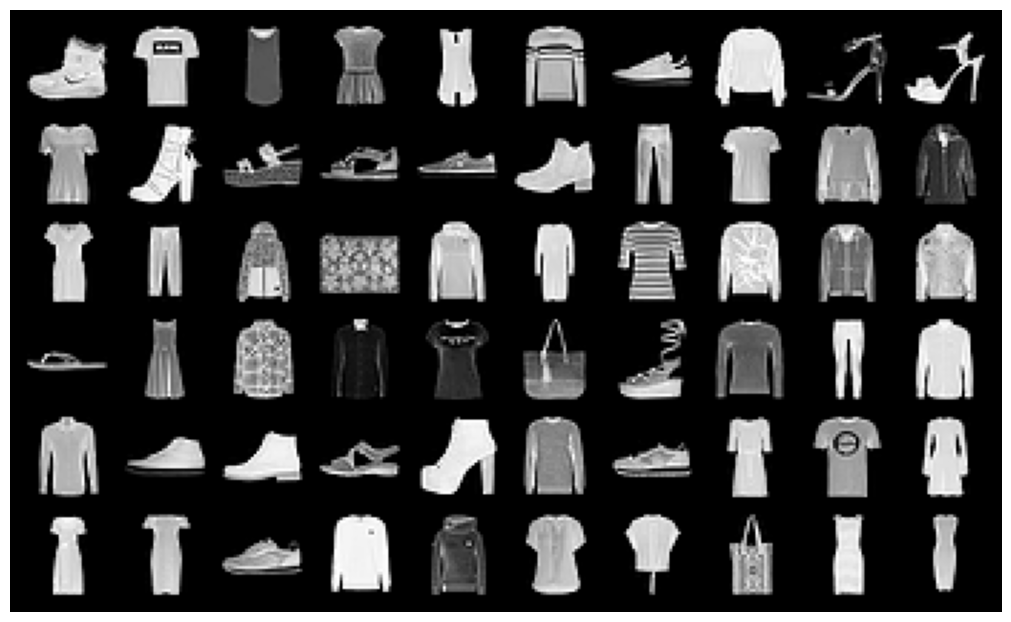

In [8]:
images_columns = 10
images_rows    = 6

def show_grid(images_tensor, images_columns, images_rows):
    image = torchvision.utils.make_grid(images_tensor, images_columns, images_rows)
    image = image.cpu().numpy()
    fig = plt.gcf()
    fig.set_size_inches(plot_w, plot_h)
    plt.axis('off')
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()

data_iterator = iter(train_loader)
images, labels = next(data_iterator)

show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)


In [9]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

## Implement a VAE neural network architecture

### Implement the network architecture

Recall that a VAE roughly consistst of two parts: The encoder (which reduces the number of dimensions and maps the input to the latent space) and the decoder (which reverses the encoding, mapping from the latent space back to the initial space).

In VAEs (compared to standard auto-encoders) we assume that the latent space is generated from a multi-variate normal distribution (N~(μ, σ²)) that is parameterized by two vectors, mean and variance. In the network, we use the log of the variance. 

In training, we sample from the distribution using the current values of the two vectors, which are updated in each step. After training, we use the mu value to draw the samples.

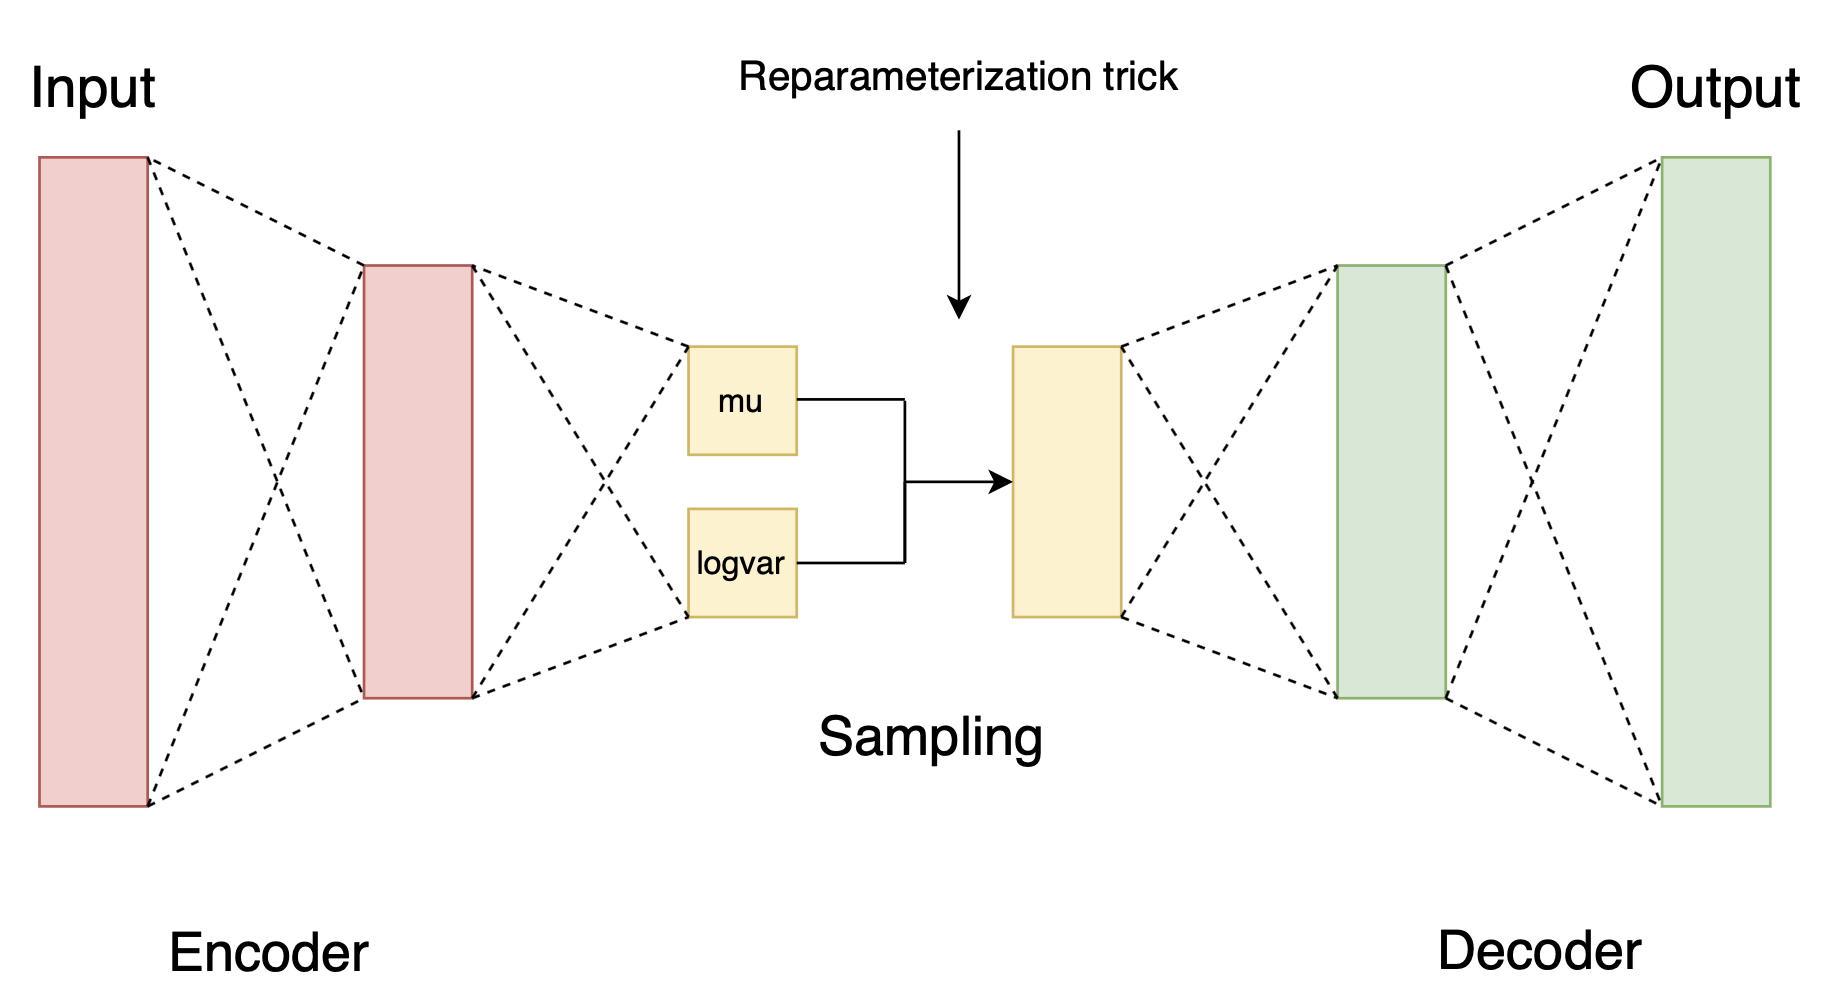

**TASK 1: Implement a VAE with the following network architecture**

We will implement a basic convolutional VAE architecture. Look at the following VAE class specification and implement it accordingly: 

**Encoder (sequential model):**
 * Convolutional Layer with (1, capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * ReLU Activation Layer
 * Convolutional Layer with (capacity, 2 * capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * ReLU Activation Layer
 
**Sampling:**
* mu, logvar: Linear Layer with 2 * capacity * 7 * 7 input features and latent_dims output features each 
* z: Linear Layer with latent_dims input features and 2 * capacity * 7 * 7 output features

**Decoder (sequential model):**
 * ConvTranspose2d Layer with (2 * capacity, capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1 
 * ReLU Activation Layer
 * ConvTranspose2d Layer with (capacity, 1) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1 
 * Sigmoid Activation Layer



**Hint**

For the sampling use the reparameterization trick:

To generate x ~ N(μ, σ²), sample ε ~ N(0, 1). Then x can be computed as x = μ + σε.

Further, remember to differentiate between training and eval: sample in training and return mu in eval.

**TODO** What does the trick do and why do we need it?

**YOUR ANSWER** We don't need to sample from the distribution we found, but only sample from the standard distribution. Because N is stochastic, it can't be optimized by gradient descent. If we put mu and sigma into N, they also wouldn't be optimized which is the opposite of our aim.


Question: why do we sample at all? -> we expect a normal distribution of the latent variables for our objects

In [10]:
# TODO Implement the VAE
class VAE(nn.Module):
    def __init__(self, capacity=1, latent_space_dim = 10):
        super(VAE, self).__init__()
        self.capacity = capacity
        self.latent_space_dim = latent_space_dim
        self.enc = nn.Sequential(
            nn.Conv2d(1,capacity,kernel_size=4,stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(capacity, 2*capacity,kernel_size=4,stride=2, padding=1),
            nn.ReLU()
        )
        
        self.mu_ll2 = nn.Linear(in_features=2*capacity*7*7, out_features=latent_space_dim)
        self.logvar_ll = nn.Linear(in_features=2*capacity*7*7, out_features=latent_space_dim)
        self.z_ll = self.mu_ll = nn.Linear(in_features=latent_space_dim, out_features=2*capacity*7*7)
        
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(2*capacity,capacity,kernel_size=4,stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(capacity, 1,kernel_size=4,stride=2, padding=1),
            nn.Sigmoid()
        )
        
        
    def forward(self, x):
        x = self.enc(x)
        mu = self.mu_ll2(x.view((-1,2*capacity*7*7)))
        logvar = self.logvar_ll(x.view((-1,2*capacity*7*7)))
        
        eps = torch.randn_like(logvar)
    
        z = mu + torch.mul(torch.sqrt(torch.exp(logvar)), eps)
        
        z = self.z_ll(z)
        z = z.view(-1, 2*capacity, 7, 7)
        z = self.dec(z)
        return z, mu, logvar
    
    def decode(self, z):
        
        z = self.z_ll(z)
        z = z.view(-1, 2*capacity, 7, 7)
        z = self.dec(z)
        return z
    
    def encode(self, x):
        x = self.enc(x)
        mu = self.mu_ll2(x.view((-1,2*capacity*7*7)))
        logvar = self.logvar_ll(x.view((-1,2*capacity*7*7)))
        
        eps = torch.randn_like(logvar)
    
        z = mu + torch.mul(torch.sqrt(torch.exp(logvar)), eps)
        
        return z
        

### Implement the loss function

Implement the two parts of the loss function: reconstruction loss using Mean Squared Error (MSE) function and the regularization part of the loss using Kullback-Leibler-Divergence (KLD).

**Hint:** 
- Make sure that you use sum instead of mean for calculating the MSE loss!
- Refer to the paper _Auto-Encoding Variational Bayes_ by Kingma and Welling to implement the loss function. 

In [13]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction losses are calculated using Mean Squared Error (MSE) and 
    # summed over all elements and batch
    mse_loss = nn.MSELoss(reduction='sum')(recon_x, x)

    # See Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    kld_loss = - 1/2 * torch.sum(1 + logvar - mu**2 - torch.exp(logvar))

    total_loss = mse_loss + kld_loss

    return total_loss#, mse_loss, kld_loss

### Instantiate the model and define the optimizer to use.

In [14]:
model10 = VAE(capacity=capacity, latent_space_dim=latent_space_dim).to(device)
optimizer = torch.optim.Adam(model10.parameters(), lr=learning_rate)

In [15]:
model10

VAE(
  (enc): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (mu_ll2): Linear(in_features=3136, out_features=10, bias=True)
  (logvar_ll): Linear(in_features=3136, out_features=10, bias=True)
  (z_ll): Linear(in_features=10, out_features=3136, bias=True)
  (mu_ll): Linear(in_features=10, out_features=3136, bias=True)
  (dec): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)

## Train the network

**TASK 2: Train the model and plot train+test set loss over training in the same plot**


In [16]:
# TODO Train and test the model
# Optimizer and loss configurations
criterion = vae_loss
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)



# Initializing the early stopping of the training
early_stopping = EarlyStopping('')

model10

# HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
loss, test_loss = run_training(train_loader, test_loader, model10, 15, criterion, optimizer, scheduler=scheduler, early_stopping=None, device=device)

60000/60000: [===============================>] - ETA 0.9sss
Epoch: 1
Training Loss: 4956.886  => Validation Loss: 3677.835
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 2
Training Loss: 3587.931  => Validation Loss: 3446.652
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 3
Training Loss: 3447.230  => Validation Loss: 3377.495
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 4
Training Loss: 3373.131  => Validation Loss: 3357.511
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 5
Training Loss: 3324.570  => Validation Loss: 3266.311
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 6
Training Loss: 3285.916  => Validation Loss: 3237.875
60000/60000: [===============================>] - ETA 0.0s
Epoch: 7
Training Loss: 3260.753  => Validation Loss: 3220.880
60000/60000: [===============================>] - ETA 0.0s
Epoch: 8
Training Loss: 3235.103  => Validation Loss: 3192.538
60000/60000: [===

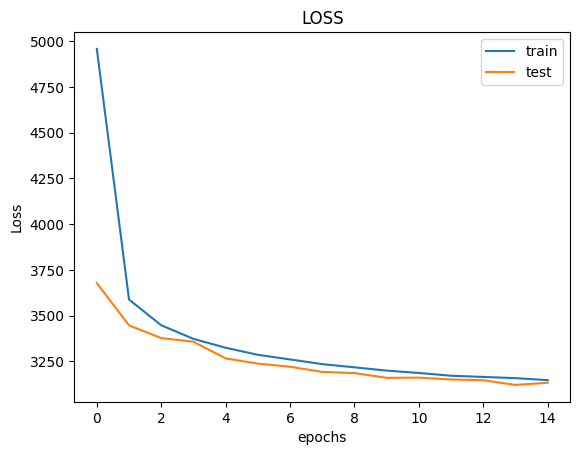

In [17]:
# TODO Plot the train and test set loss during training in the same plot!

get_metric_plots(loss, test_loss, "Loss")

### Visualization of random samples from the latent space via decoding

Here we just create a number of random samples from the latent space and use the decoder to generate images from them. Rerun the code cell to generate new samples every time!

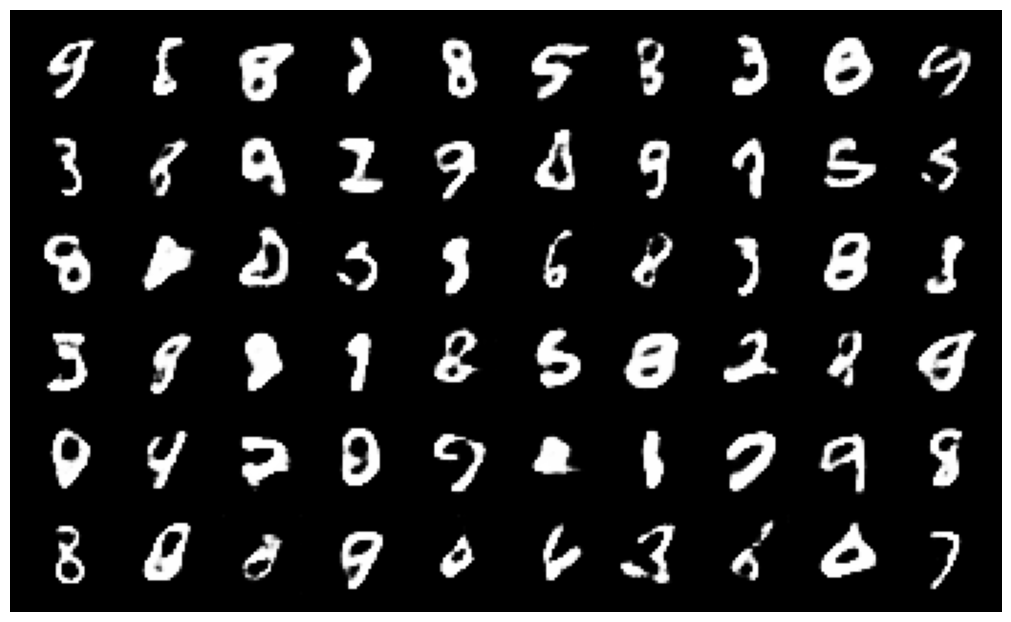

In [62]:
with torch.no_grad():
    samples = torch.randn(images_columns * images_rows, latent_space_dim).to(device)
    samples = model10.decode(samples).cpu()

    show_grid(samples[0:(images_columns * images_rows)], images_columns, images_rows)

### Visualization of image reconstructions

Visualize the image reconstruction process and compare the reconstructions to the original images.

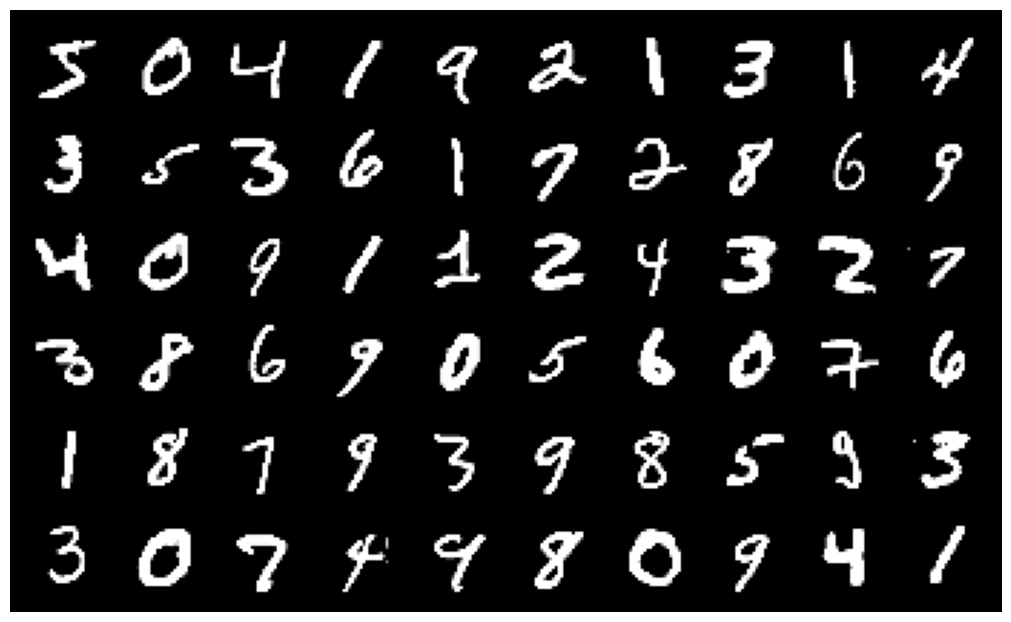

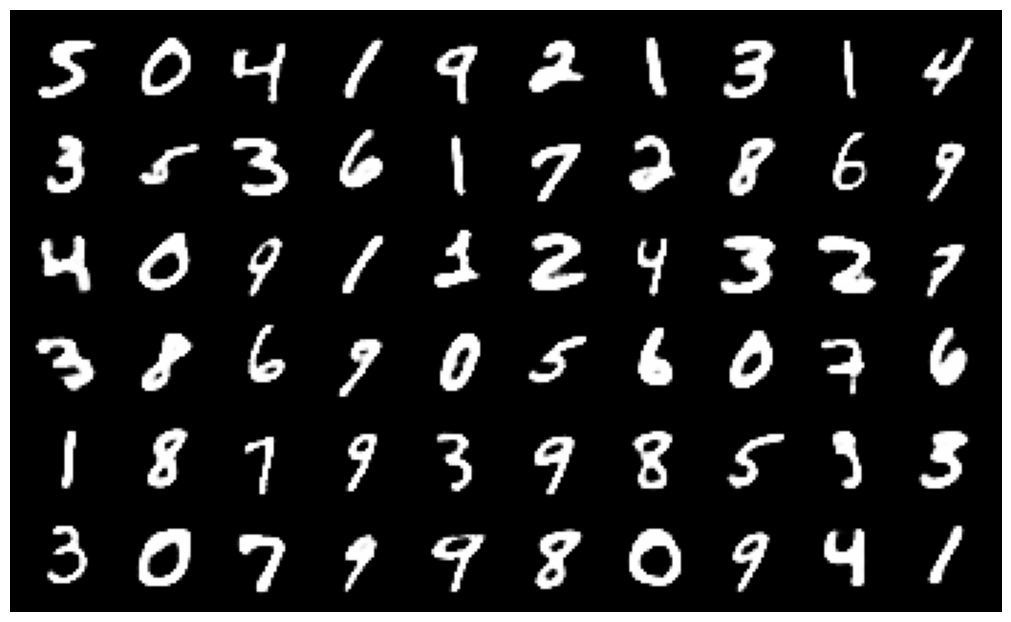

In [65]:
images_columns = 10
images_rows    = 6

#data_iterator = iter(train_loader)
#images, labels = data_iterator.next()

images = torch.zeros((images_columns*images_rows, 28,28)).to(device)
images_recon = torch.zeros((images_columns*images_rows, 28,28)).to(device)

# Show reconstructed images
model.eval()
with torch.no_grad():
    for index, (image, label) in enumerate(train_loader):
        if index>(images_columns*images_rows)/batch_size:
            break
        images = image[0:images_columns*images_rows]
        image = image.to(device)
        images_recon = model10(image)[0][0:images_columns*images_rows,::,::,::]

# Show original images
show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)

show_grid(images_recon[0:(images_columns * images_rows)], images_columns, images_rows)

### Optimization

**TASK 3: Explore dimensionality of latent space**

How does the dimensionality of latent space (set to 10 by default in our case) affect loss and quality of the reconstructions? Explore smaller and larger latent dimensionality by using 2, 4, 8, 16, 32 dimensions and looking at reconstructions and resulting test set losses. 

We observe good results for lat dims of 8 to 16. Beyond it doesn't improve much

Model with latent space dimension of 2
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 1
Training Loss: 76297.628  => Validation Loss: 11563.638
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 2
Training Loss: 70665.712  => Validation Loss: 12967.124
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 3
Training Loss: 69585.347  => Validation Loss: 12930.671
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 4
Training Loss: 68890.193  => Validation Loss: 13028.609
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 5
Training Loss: 68395.928  => Validation Loss: 13032.130
Finished Training


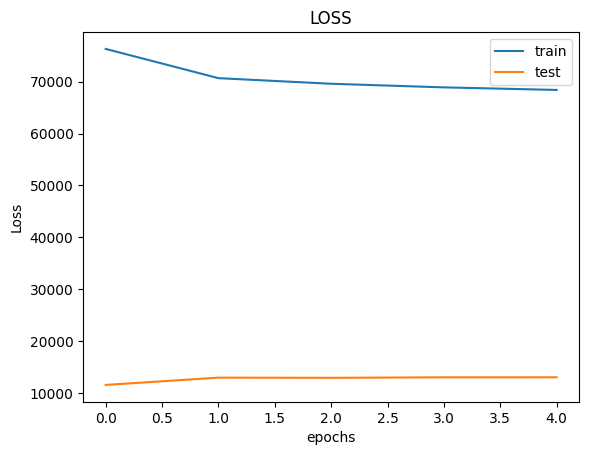

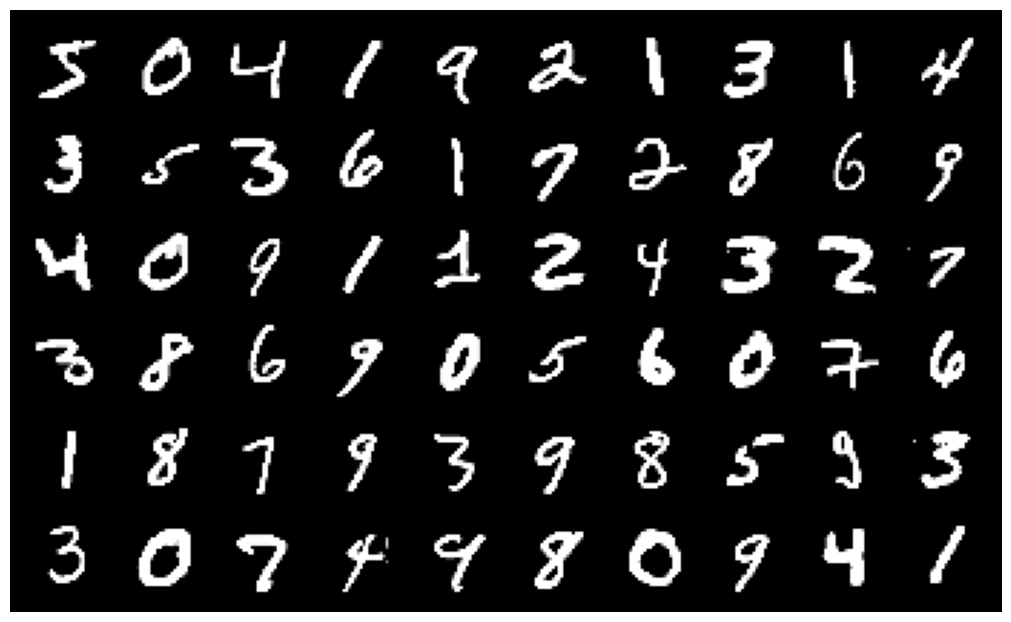

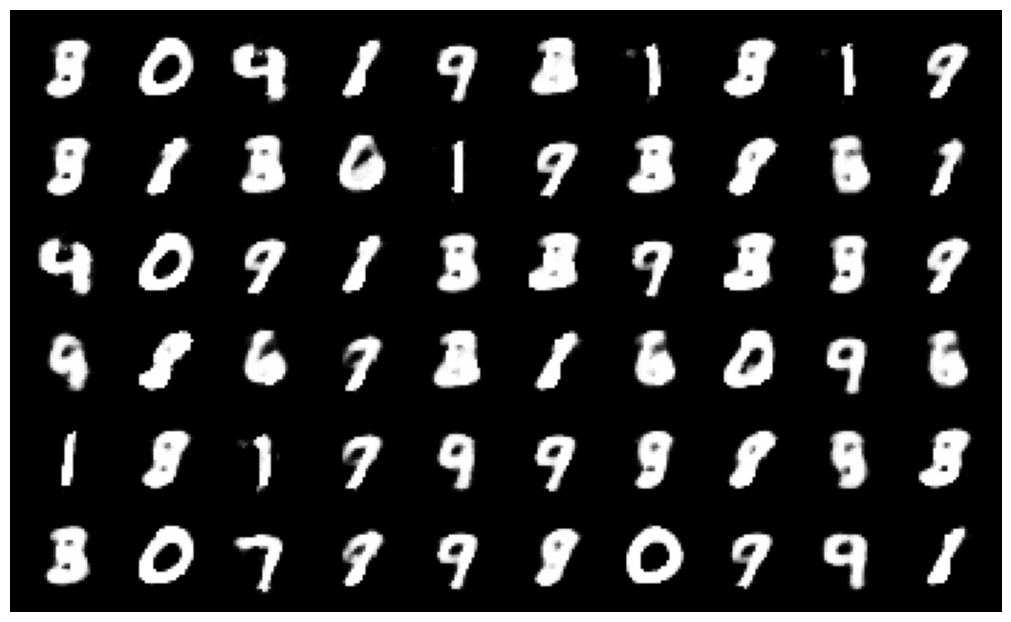

Model with latent space dimension of 4
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 1
Training Loss: 70938.762  => Validation Loss: 11363.342
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 2
Training Loss: 64280.243  => Validation Loss: 12208.734
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 3
Training Loss: 63013.144  => Validation Loss: 12448.142
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 4
Training Loss: 62282.743  => Validation Loss: 12656.086
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 5
Training Loss: 61817.836  => Validation Loss: 12811.652
Finished Training


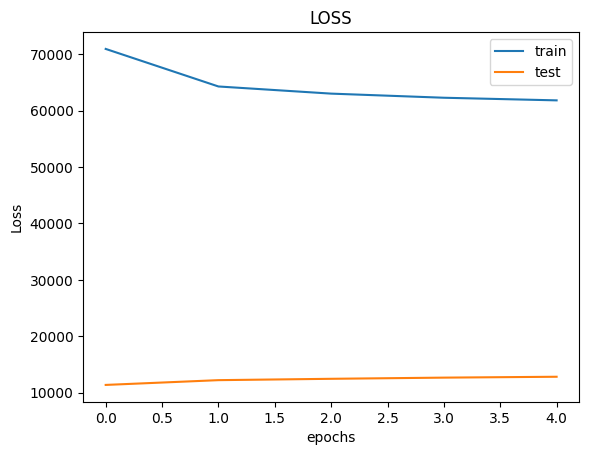

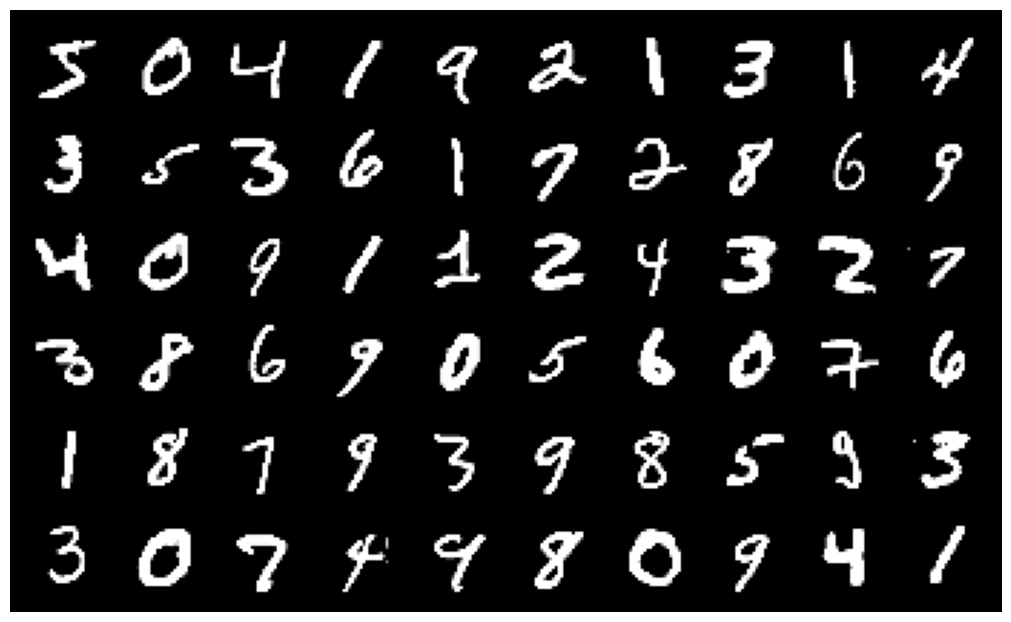

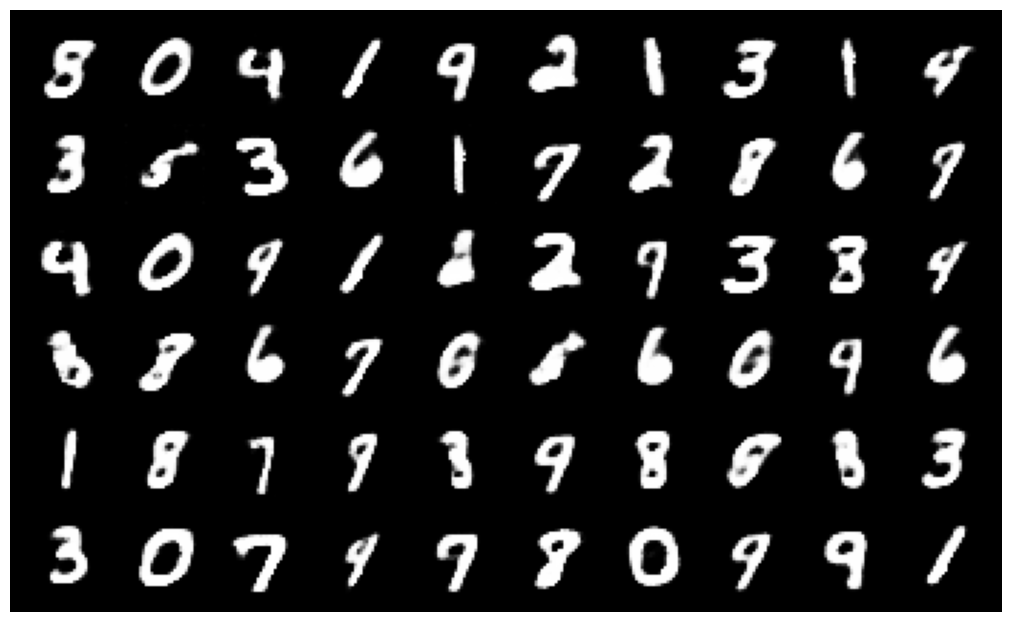

Model with latent space dimension of 8
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 1
Training Loss: 67439.169  => Validation Loss: 14745.403
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 2
Training Loss: 60237.302  => Validation Loss: 13141.760
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 3
Training Loss: 58892.193  => Validation Loss: 12842.188
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 4
Training Loss: 58121.999  => Validation Loss: 12989.595
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 5
Training Loss: 57618.945  => Validation Loss: 13458.449
Finished Training


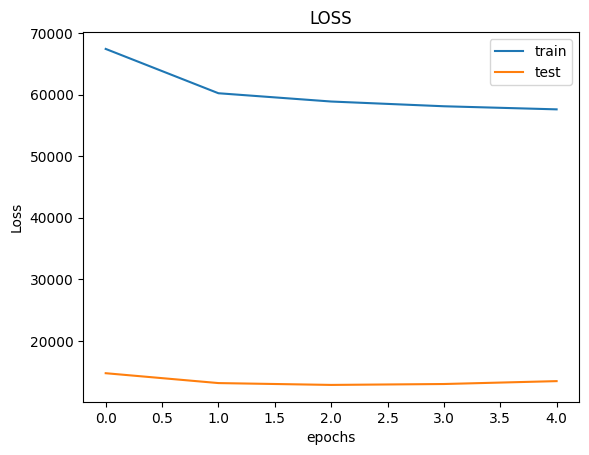

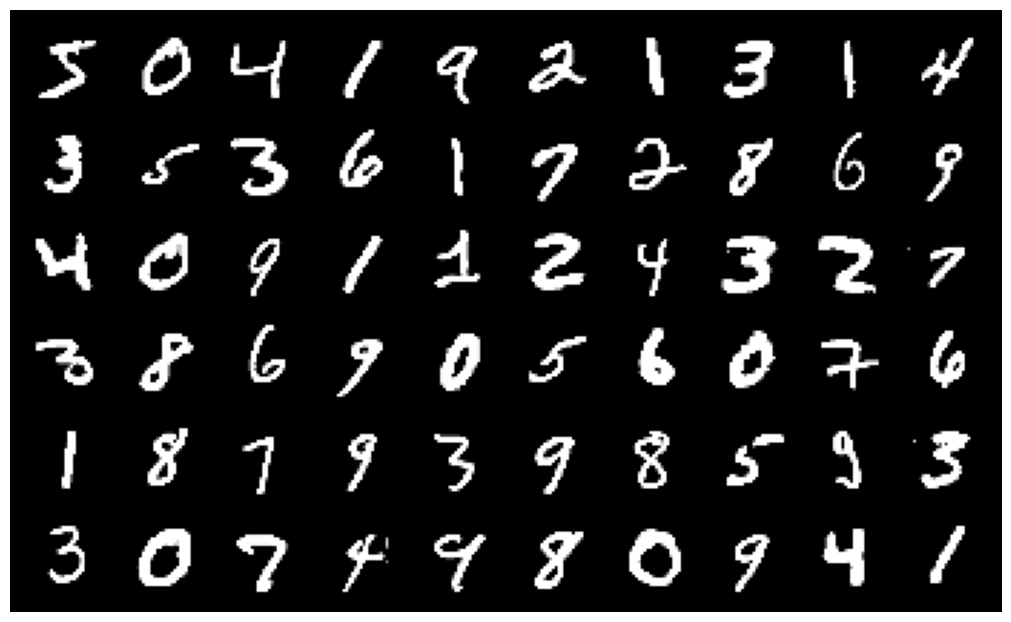

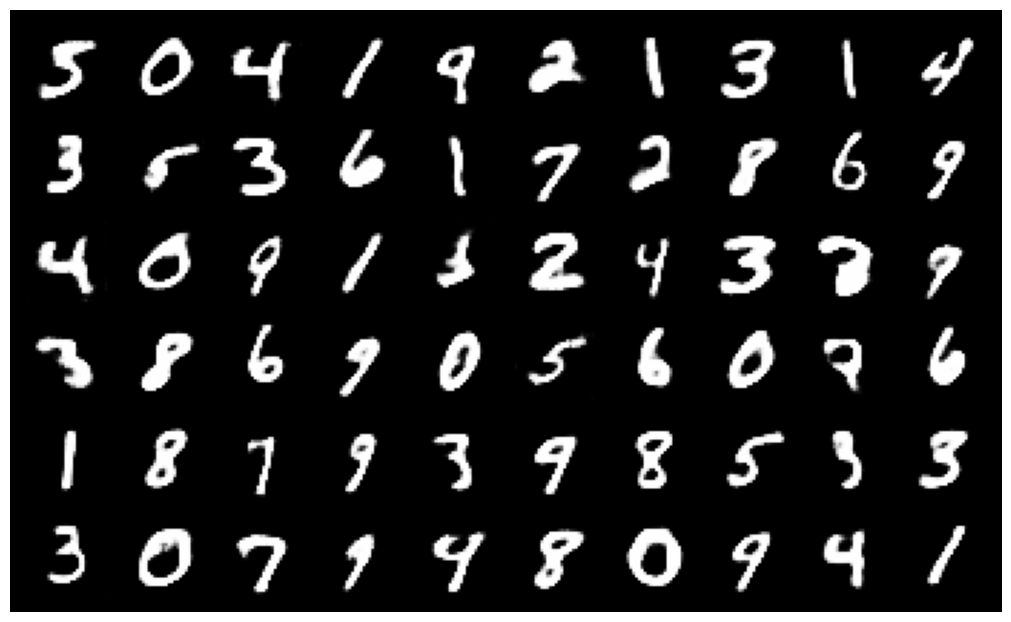

Model with latent space dimension of 16
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 1
Training Loss: 64082.636  => Validation Loss: 15634.651
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 2
Training Loss: 57382.825  => Validation Loss: 13071.337
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 3
Training Loss: 56322.311  => Validation Loss: 12905.085
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 4
Training Loss: 55712.366  => Validation Loss: 13010.237
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 5
Training Loss: 55332.129  => Validation Loss: 13295.679
Finished Training


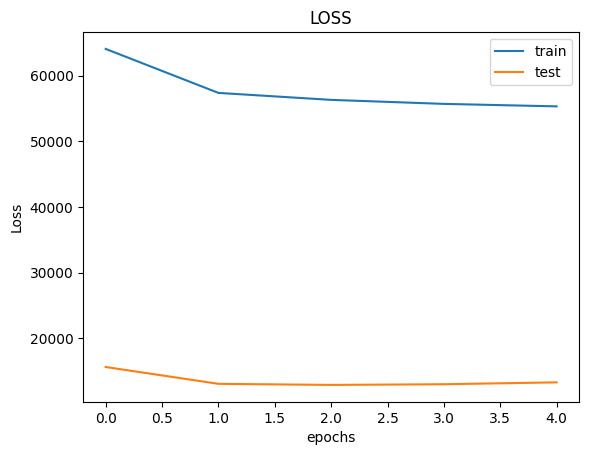

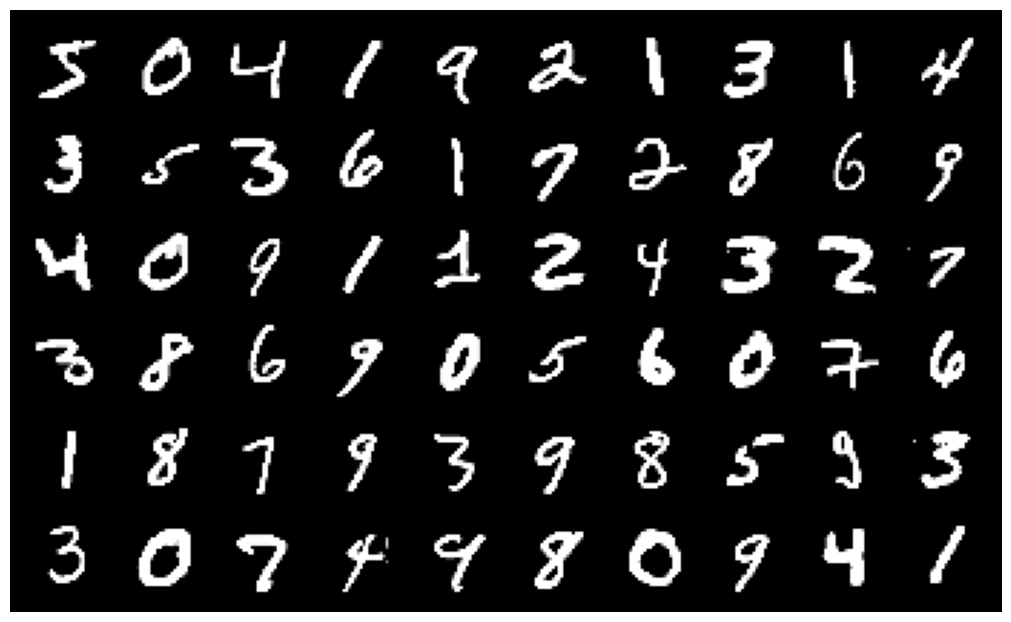

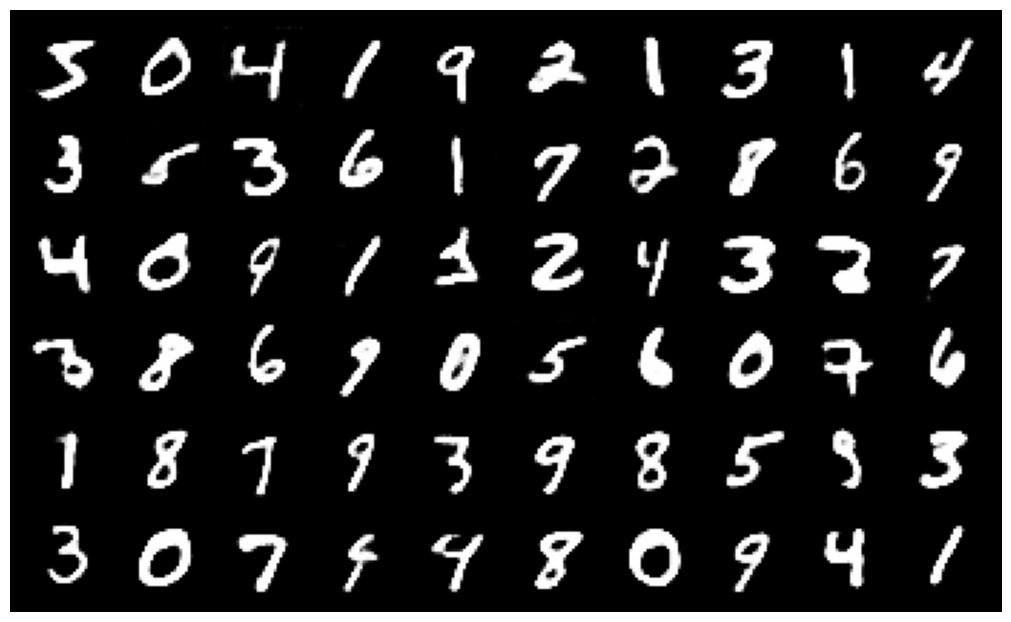

Model with latent space dimension of 32
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 1
Training Loss: 62945.104  => Validation Loss: 19220.823
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 2
Training Loss: 56306.055  => Validation Loss: 15888.173
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 3
Training Loss: 55608.107  => Validation Loss: 13399.157
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 4
Training Loss: 55196.901  => Validation Loss: 13367.710
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 5
Training Loss: 54940.244  => Validation Loss: 13437.630
Finished Training


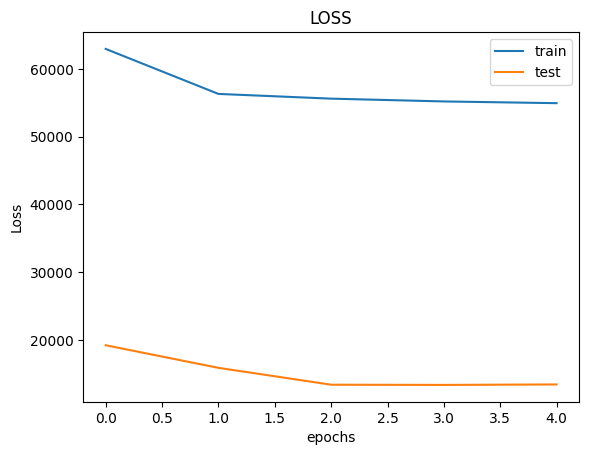

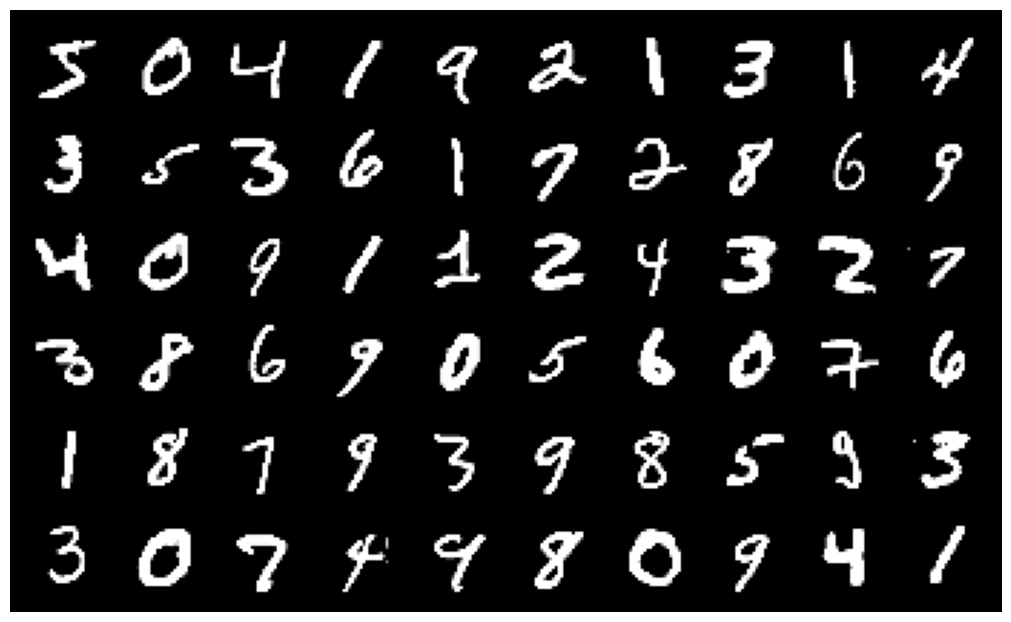

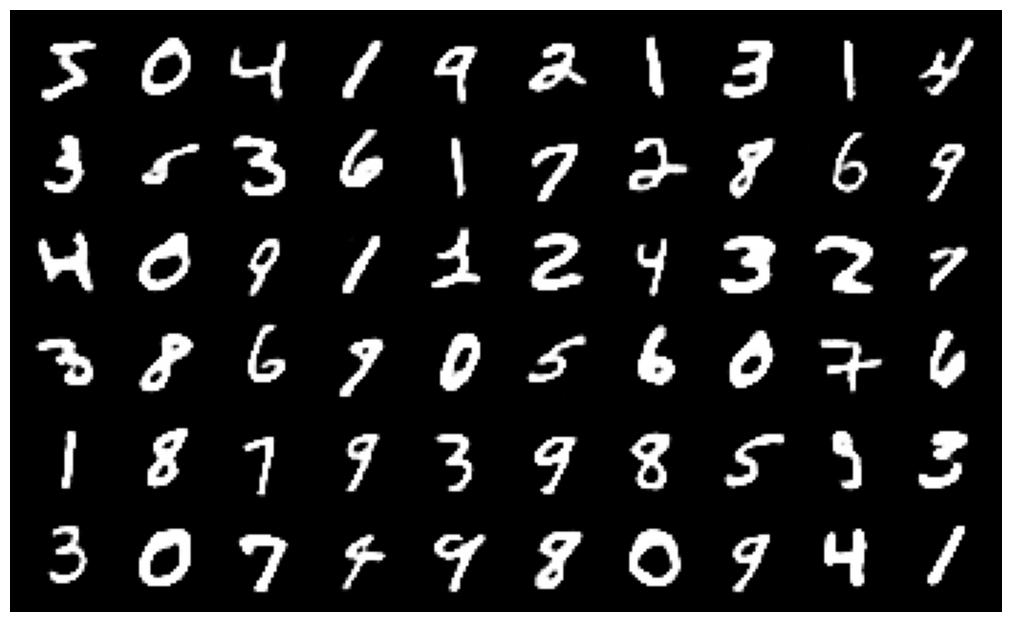

In [66]:
# TODO
latent_dim_arr = [2,4,8,16,32]
images_columns = 10
images_rows    = 6


for latent_dim in latent_dim_arr:
    print("Model with latent space dimension of " + str(latent_dim))
    model = VAE(capacity=capacity, latent_space_dim=latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # TODO Train and test the model
    # Optimizer and loss configurations
    criterion = vae_loss
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    # Initializing the early stopping of the training
    early_stopping = EarlyStopping('')

    loss, test_loss = run_training(train_loader, test_loader, model, epochs, criterion, optimizer, scheduler=scheduler, early_stopping=None, device=device)
    
    get_metric_plots(loss, test_loss, "Loss")

    images = torch.zeros((images_columns*images_rows, 28,28)).to(device)
    images_recon = torch.zeros((images_columns*images_rows, 28,28)).to(device)

    # Show reconstructed images
    model.eval()
    with torch.no_grad():
        for index, (image, label) in enumerate(train_loader):
            if index>(images_columns*images_rows)/batch_size:
                break
            images = image[0:images_columns*images_rows]
            image = image.to(device)
            images_recon = model(image)[0][0:images_columns*images_rows,::,::,::]

    # Show original images
    show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)

    show_grid(images_recon[0:(images_columns * images_rows)], images_columns, images_rows)

## Visualization of latent traversals

**TASK 4: Plot some latent traversals**

Latent traversal is a popular approach to visualize the disentangled latent representations. Given a bunch of variations in a single unit of the latent representation, it is expected that there is a change in a single factor of variation of the data while others are fixed. (See paper [Learning Disentangled Representations with Latent Variation Predictability](https://arxiv.org/abs/2007.12885))

Remember in the previous task you trained models with different latent dimensions. Each shape is encoded into a `latent_dim`-sized vector. In this task we want to see which shapes are reconstructed if we create a latent code where we set

- one of these dimensions (e.g. dim1=11) to different values ($x_i \in [-3,3]$)
- two of these dimensions (e.g. dim1=31, dim2=4) to different values ($x_i, x_j \in [-3,3]$)

while setting all other values of the latent code to $0$. Use the decoder of the VAE neural network to create images from these latent codes.

**TODO** Create a 1 x 10 array plot for the first visualization and a 10 x 10 matrix plot for the second showing latent space travels.

**TODO** Repeat the experiment, now setting the other dimensions of the vector to a random value in [-1,1] instead of zero. Write down what you observe.

Here are two examples.

1x10 traversal of one latent dimension

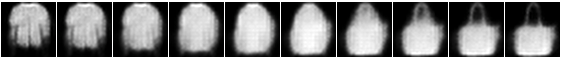

10x10 traversal of two latent dimensions

![10x10 traversal of two latent dimensions](https://i.imgur.com/hZXIYzv.png)

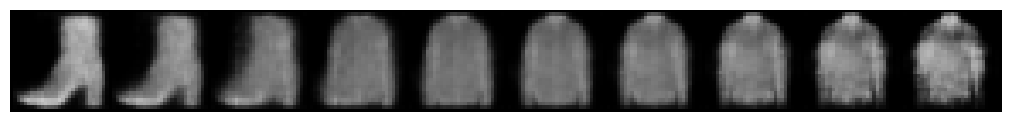

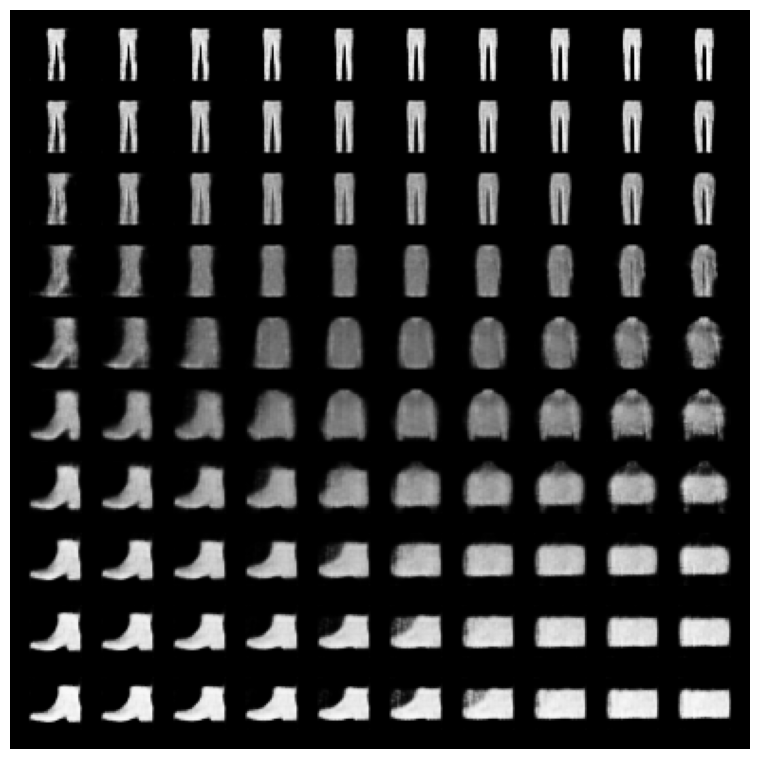

In [44]:
# TODO for other entries 0
with torch.no_grad():
    # variate one dimension
    samples = torch.zeros((10,10)).to(device)
    samples[::,4] = torch.linspace(-3,3,10)
    samples = model10.decode(samples)

    show_grid(samples[0:(10)], 10, 1)
    
    #variate two dimensions
    samples = torch.zeros((10,10,10)).to(device)
    samples[::,::,4] = torch.mul(torch.ones((10,1)),torch.linspace(-3,3,10).view(1,10))
    samples[::,::,8] = torch.mul(torch.linspace(-3,3,10).view(10,1), torch.ones((1,10)))
    samples = model10.decode(samples)

    show_grid(samples[0:(10*10)], 10, 10)

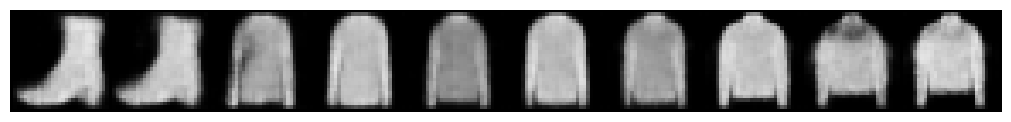

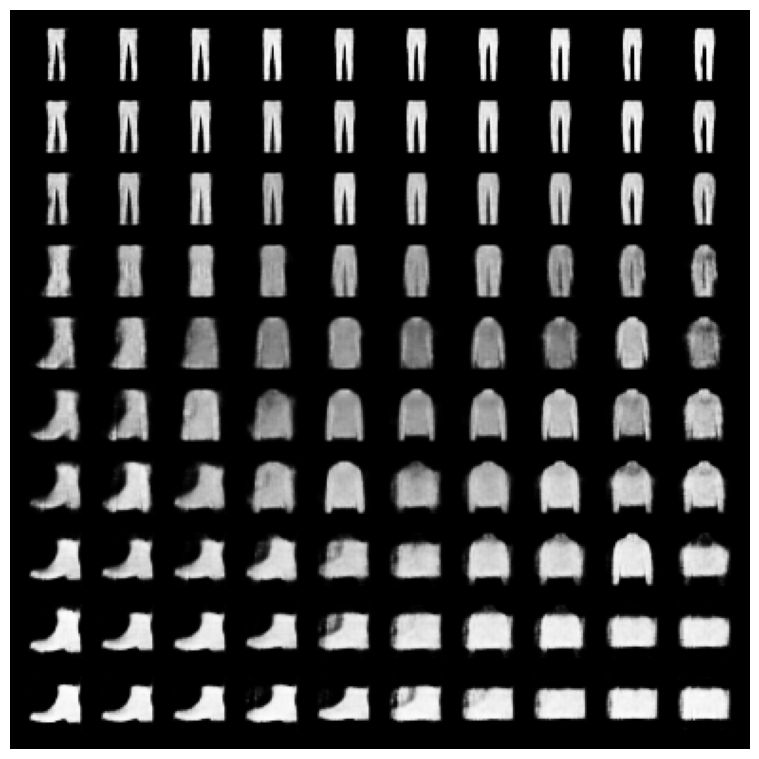

In [45]:
# TODO for other entries random
with torch.no_grad():
    # variate one dimension
    samples = torch.rand((10,10)).to(device)
    samples[::,4] = torch.linspace(-3,3,10)
    samples = model10.decode(samples)

    show_grid(samples[0:(10)], 10, 1)
    
    #variate two dimensions
    samples = torch.rand((10,10,10)).to(device)
    samples[::,::,4] = torch.mul(torch.ones((10,1)),torch.linspace(-3,3,10).view(1,10))
    samples[::,::,8] = torch.mul(torch.linspace(-3,3,10).view(10,1), torch.ones((1,10)))
    samples = model10.decode(samples)

    show_grid(samples[0:(10*10)], 10, 10)

### Visualize class labels in latent space

**TASK 5: Visualize class labels in latent space**

First create a new VAE-model with a 2d latent space on the full training data set. Then project all the images of the training set into the 2d latent space keeping track of their class labels. Use a 2d scatter plot to visualize the resulting latent space vectors and different colors for their labels. 

- Do images of the same class cluster in latent space?
- Do the data points in latent space look like a normal distribution?

**Your answer here**

They cluster very nicely although they have a big overlap. The distributions like quite similar to gaussian. However some points don't follow this.

#### Train 2d latent space model

Model with latent space dimension of 2
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 1
Training Loss: 76152.933  => Validation Loss: 12882.231
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 2
Training Loss: 70625.411  => Validation Loss: 14225.525
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 3
Training Loss: 69469.530  => Validation Loss: 14376.032
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 4
Training Loss: 68872.674  => Validation Loss: 14280.445
60000/60000: [===============================>] - ETA 0.0ss
Epoch: 5
Training Loss: 68457.045  => Validation Loss: 14284.823
Finished Training


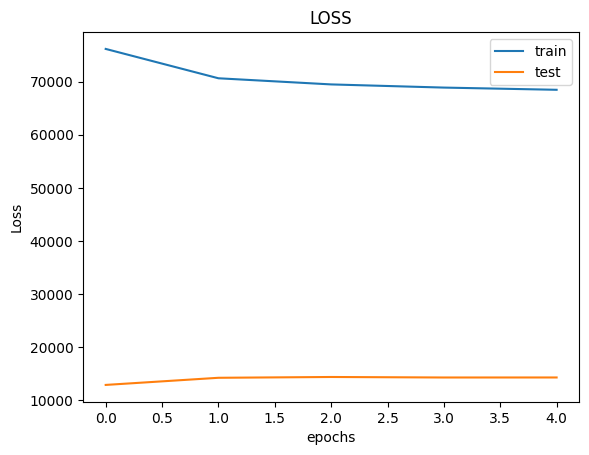

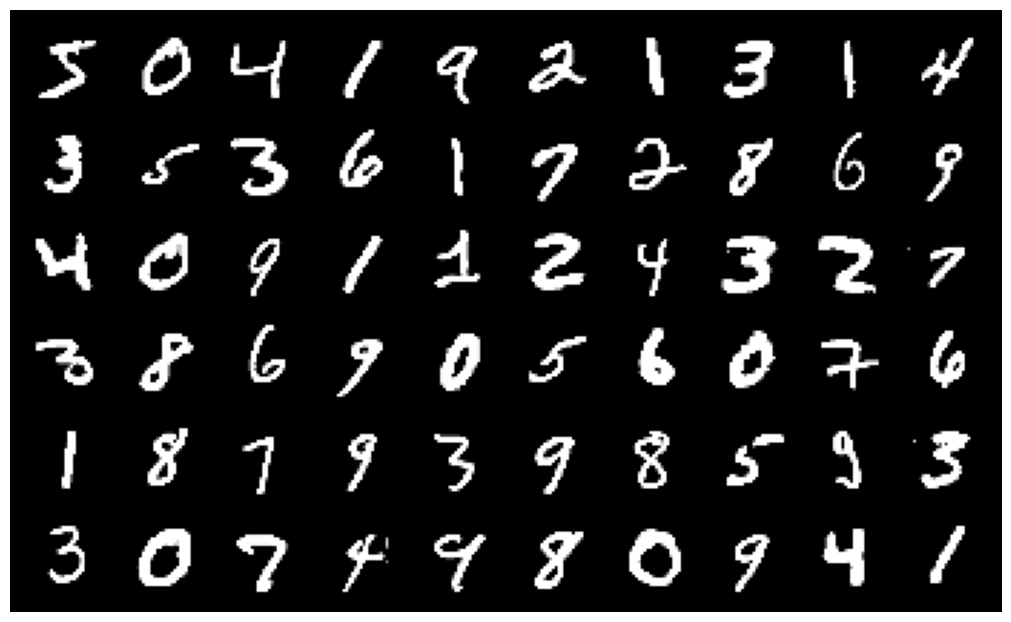

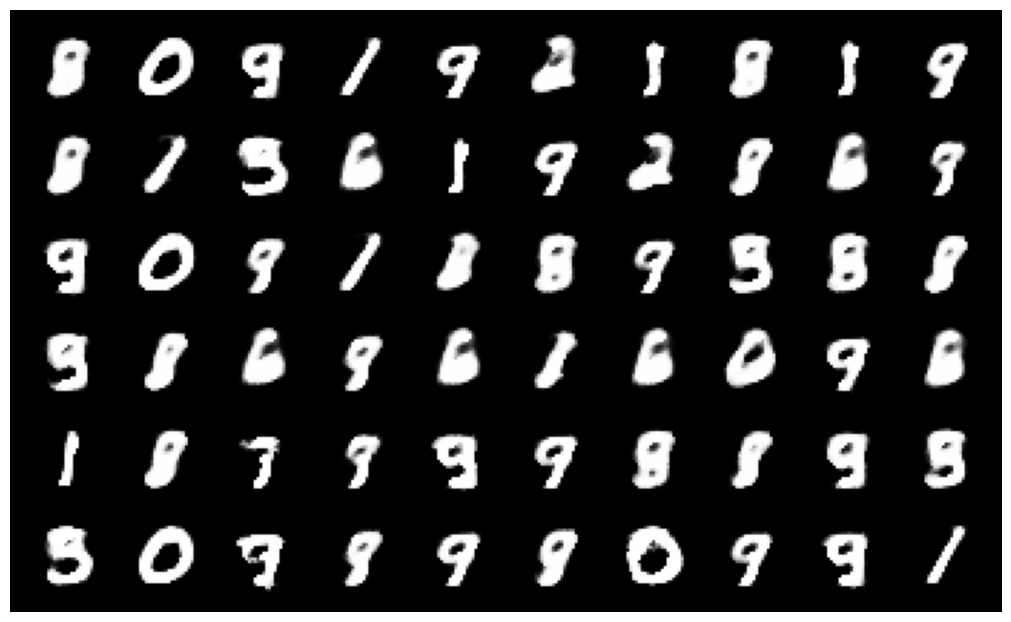

In [69]:
# TODO
latent_dim = 2

print("Model with latent space dimension of " + str(latent_dim))
model = VAE(capacity=capacity, latent_space_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# TODO Train and test the model
# Optimizer and loss configurations
criterion = vae_loss
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# Initializing the early stopping of the training
early_stopping = EarlyStopping('')

loss, test_loss = run_training(train_loader, test_loader, model, epochs, criterion, optimizer, scheduler=scheduler, early_stopping=None, device=device)

get_metric_plots(loss, test_loss, "Loss")

images = torch.zeros((images_columns*images_rows, 28,28)).to(device)
images_recon = torch.zeros((images_columns*images_rows, 28,28)).to(device)

# Show reconstructed images
model.eval()
with torch.no_grad():
    for index, (image, label) in enumerate(train_loader):
        if index>(images_columns*images_rows)/batch_size:
            break
        images = image[0:images_columns*images_rows]
        image = image.to(device)
        images_recon = model(image)[0][0:images_columns*images_rows,::,::,::]

# Show original images
show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)

show_grid(images_recon[0:(images_columns * images_rows)], images_columns, images_rows)

#### Visualize classes

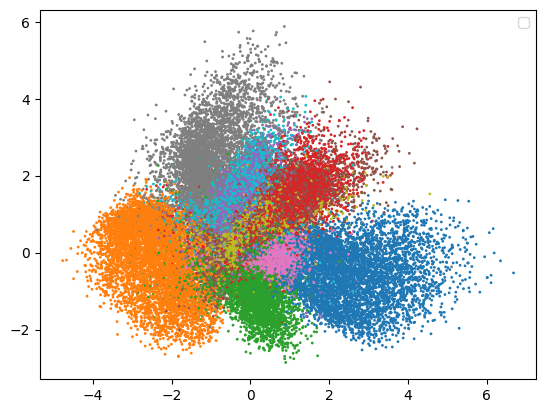

In [70]:
# TODO
for i, data in enumerate(train_loader):
    # getting the training inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    # forward pass, backward pass, optimize
    outputs = model.encode(inputs)
    outputs = outputs.cpu().detach().numpy()
    labels = labels.cpu().numpy()
    plt.scatter(outputs[::,0], outputs[::,1],c=labels, cmap=plt.get_cmap('tab10'), s=1)


plt.show()

# Appendix [OPTIONAL]


Use standard MNIST or CIFAR-10 instead of fashion MNIST.

In [52]:
transform = transforms.Compose([ 
               transforms.Resize(image_size),
                transforms.ToTensor(),
               transforms.Normalize((0.1307,), (0.3081,))
            ])

train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(data_dir, train=False, transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 114985663.32it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 47006478.01it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33817547.63it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8179703.21it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

